# Imports

In [1]:
import pandas as pd
from datetime import datetime
%matplotlib inline
%reload_ext watermark
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sb
from IPython.display import display
import sklearn as sk
import sklearn.neural_network as sknn


# Data

In this section we load both datasets we use, COVID-19 dataset and countries population dataset , clean the data and add some new columns.  

The datasets we use are:

* https://www.kaggle.com/imdevskp/corona-virus-report for the COVID-19 dataset

* https://www.kaggle.com/tanuprabhu/population-by-country-2020 for population information per country


## COVID-19 Dataset

In [2]:
# Loading datasets

full_table = pd.read_csv('datasets/covid_19_clean_complete.csv', 
                          na_values=['NaN'],
                          parse_dates=['Date'])
# full_table = full_table.sort_values(['Date','Country/Region'],ascending=[True, False])

# Adding Active cases column
full_table['Active'] = (full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']).apply(lambda x: x if x >= 0 else 0)

# filling missing values
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[['Confirmed','Deaths','Recovered','Active']] = full_table[['Confirmed','Deaths','Recovered','Active']].fillna(0)

full_table.sample(6)


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
13602,,Croatia,45.1000,15.2000,2020-03-13,32,0,1,31
1403,Tibet,China,31.6927,88.0924,2020-01-27,0,0,0,0
13716,,Spain,40.0000,-4.0000,2020-03-13,5232,133,193,4906
29461,,Central African Republic,6.6111,20.9394,2020-05-12,143,0,10,133
26753,,Burundi,-3.3731,29.9189,2020-05-01,11,1,4,6
7514,,Denmark,56.2639,9.5018,2020-02-19,0,0,0,0


## Population Dataset


In [3]:
pop_table = pd.read_csv('datasets/population_by_country_2020.csv',
                        na_values=['N.A.'])


# Selecting only the Country and Population columns
pop_table = pop_table.iloc[:,[0,1,4,9]]



# Renaming columns
pop_table.columns = ['Country/Region', 'Population', 'Population Density (P/Km²)','Urban Population %']

# Most of the entries with urban population as NaN in the population dataset that we are going to use have 100% as of 2020
pop_table[['Urban Population %']] = pop_table[['Urban Population %']].fillna('100 %')
pop_table['Urban Population %'] = pop_table['Urban Population %'].map(lambda x: int(x.split(' ')[0]))


In [4]:
pop_table.info()
pop_table.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Country/Region              235 non-null    object
 1   Population                  235 non-null    int64 
 2   Population Density (P/Km²)  235 non-null    int64 
 3   Urban Population %          235 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ KB


Country/Region                0
Population                    0
Population Density (P/Km²)    0
Urban Population %            0
dtype: int64

## Removing ship data

The dataset also includes data from the various ships that had COVID19 outbreaks. Since we only need the information per country we removed it from the dataset.

In [5]:
# ship rows
ship_rows = full_table['Province/State'].str.contains('Grand Princess') | full_table['Province/State'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('Diamond Princess') | full_table['Country/Region'].str.contains('MS Zaandam')

# ship
ship = full_table[ship_rows]

# dropping ship rows 
full_table = full_table[~(ship_rows)]

ship.sample(6)


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
14541,Diamond Princess,Canada,0.0000,0.0000,2020-03-16,0,0,0,0
25691,,MS Zaandam,0.0000,0.0000,2020-04-27,9,2,0,7
27016,,MS Zaandam,0.0000,0.0000,2020-05-02,9,2,0,7
26853,,Diamond Princess,0.0000,0.0000,2020-05-02,712,13,645,54
6132,Grand Princess,Canada,37.6489,-122.6655,2020-02-14,0,0,0,0
16732,Grand Princess,Canada,37.6489,-122.6655,2020-03-25,13,0,0,13


## Fixing country names


### Fixing mismatched names between datasets

Here we manually set the names so that the join between datasets works.


In [6]:
fix_name_only = {
    'Sao Tome & Principe': 'Sao Tome and Principe',
    "Côte d'Ivoire": "Cote d'Ivoire",
    "United States": "US",
    "Czech Republic (Czechia)": 'Czechia',
    'Myanmar': 'Burma',
    'Taiwan': 'Taiwan*',
    'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
    'Macao' : 'Macau'
}

for original,new in fix_name_only.items():
    full_table.loc[full_table['Country/Region'] == new, 'Country/Region'] = original
    full_table.loc[full_table['Province/State'] == new, 'Province/State'] = original

missing_countries = set(full_table['Country/Region']).difference(set(pop_table['Country/Region']))

# # print(sorted(pop_table['Country/Region'].unique()))
# if len(missing_countries) != 0:
#     print(missing_countries)


### Replacing Country/Region with Province/State

The population dataset has entries for autonomous regions, for example Greenland. Here we rewrite the Country/Region column with the Province/State name so we can easily join the population dataset. For example, Greenland exists in the population dataset so what we do is replace Denmark (the Country column of Greenland) with Greenland.

In [7]:

province_set = set(full_table['Province/State']).intersection(set(pop_table['Country/Region']))

no_data = set(['Saint Vincent and the Grenadines','Kosovo','Congo','West Bank and Gaza'])

for province in province_set:
    if province in no_data:
        continue
    full_table.loc[ full_table['Province/State'] == province,'Country/Region'] = province 



In [8]:
# Check for null values
full_table.isna().sum()

Province/State    0
Country/Region    0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
Active            0
dtype: int64

## Grouping data

Here we are grouping data by Date and Country so we can add population and cases per million afterwards.

In [9]:
full_grouped = full_table.groupby(['Country/Region','Lat','Long','Date'])['Confirmed','Deaths','Recovered','Active'].sum().reset_index()


### Adding population
In this section, we merge both datasets by Country/Region.

In [10]:
full_grouped = pd.merge(full_grouped,pop_table,on=['Country/Region'])


In [11]:
# Check information on types and null values
full_grouped.info()
full_grouped.loc[full_grouped['Urban Population %'].isnull()]['Country/Region'].unique()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 30976 entries, 0 to 30975
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Country/Region              30976 non-null  object        
 1   Lat                         30976 non-null  float64       
 2   Long                        30976 non-null  float64       
 3   Date                        30976 non-null  datetime64[ns]
 4   Confirmed                   30976 non-null  int64         
 5   Deaths                      30976 non-null  int64         
 6   Recovered                   30976 non-null  int64         
 7   Active                      30976 non-null  int64         
 8   Population                  30976 non-null  int64         
 9   Population Density (P/Km²)  30976 non-null  int64         
 10  Urban Population %          30976 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(1)


array([], dtype=object)

In [16]:
full_grouped.sample(6)

,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,Population,Population Density (P/Km²),Urban Population %
15092,Gibraltar,36.1408,-5.3536,2020-04-19,132,0,120,12,33693,3369,100
12083,Denmark,61.8926,-6.9118,2020-05-05,187,0,185,2,5788108,137,88
26745,Somalia,5.1521,46.1996,2020-01-26,0,0,0,0,15798020,25,47
11034,Comoros,-11.6455,43.3333,2020-02-14,0,0,0,0,865696,467,29
29722,United Kingdom,21.6940,-71.7979,2020-04-08,8,1,0,7,67814098,281,83
8777,China,31.6927,88.0924,2020-03-27,1,0,1,0,1438207241,153,61


### Calculating Cases per Million of People




In [26]:
full_grouped['Confirmed per million'] = (full_grouped['Confirmed'] / full_grouped['Population']) * 1000000
full_grouped['Deaths per million'] = (full_grouped['Deaths'] / full_grouped['Population']) * 1000000
full_grouped['Recovered per million'] = (full_grouped['Recovered'] / full_grouped['Population']) * 1000000
full_grouped['Active per million'] = (full_grouped['Active'] / full_grouped['Population']) * 1000000
per_million = full_grouped.iloc[:,[0,1,2,3,9,10,11,12,13,14,]]


per_million.sample(20)


,Country/Region,Lat,Long,Date,Population Density (P/Km²),Urban Population %,Confirmed per million,Recovered per million,Deaths per million,Active per million
30703,Yemen,15.552727,48.516388,2020-04-21,56,38,0.033685,0.000000,0.000000,0.033685
21142,Mexico,23.634500,-102.552800,2020-04-19,66,84,64.210191,20.418856,5.332065,38.459270
27265,Spain,40.000000,-4.000000,2020-03-02,94,80,2.566780,0.042780,0.000000,2.524001
4283,Brunei,4.535300,114.727700,2020-03-10,83,80,2.290300,0.000000,0.000000,2.290300
18599,Kyrgyzstan,41.204400,74.766100,2020-04-17,34,36,75.209896,17.533595,0.769017,56.907283
26680,Slovenia,46.151200,14.995500,2020-03-22,103,55,199.145598,0.000000,0.962056,198.183542
10823,China,47.862000,127.761500,2020-03-16,153,61,0.335139,0.000000,0.009039,0.326100
14017,France,46.227600,2.213700,2020-05-03,119,82,2563.766629,765.932791,381.088846,1416.744992
17471,Isle of Man,54.236100,-4.548100,2020-03-09,149,53,0.000000,0.000000,0.000000,0.000000
24202,Philippines,13.000000,122.000000,2020-01-24,368,47,0.000000,0.000000,0.000000,0.000000


### Value Truncation

Since the COVID-19 dataset only has data from  22nd of January of 2020 onwards, we will define Date from here moving foward as days since the 22nd of January of 2020.

In [27]:
per_million['Date'].min()

Timestamp('2020-01-22 00:00:00')

This function does that:

In [30]:
def daysSinceJan(d):
    return d.toordinal() - datetime(2020,1,20).toordinal()

per_million['Date'] = per_million['Date'].map(daysSinceJan)

In [32]:
per_million.sample(20)
per_million.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30976 entries, 0 to 30975
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Country/Region              30976 non-null  object 
 1   Lat                         30976 non-null  float64
 2   Long                        30976 non-null  float64
 3   Date                        30976 non-null  int64  
 4   Population Density (P/Km²)  30976 non-null  int64  
 5   Urban Population %          30976 non-null  int64  
 6   Confirmed per million       30976 non-null  float64
 7   Recovered per million       30976 non-null  float64
 8   Deaths per million          30976 non-null  float64
 9   Active per million          30976 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 3.8+ MB


,Date,Country/Region,Province/State,C/D/R,Cases
0,2020-01-22,Portugal,,Confirmed,0
1,2020-01-22,Spain,,Confirmed,0
2,2020-01-23,Portugal,,Confirmed,0
3,2020-01-23,Spain,,Confirmed,0
4,2020-01-24,Portugal,,Confirmed,0
...,...,...,...,...,...
721,2020-05-19,Spain,,Recovered,150376
722,2020-05-20,Portugal,,Recovered,6452
723,2020-05-20,Spain,,Recovered,150376
724,2020-05-21,Portugal,,Recovered,6452


,count,mean,std,min,25%,50%,75%,max
Lat,242.0,39.699950,0.300672,39.3999,39.3999,39.69995,40.00,40.0
Long,242.0,-6.112250,2.116628,-8.2245,-8.2245,-6.11225,-4.00,-4.0
Confirmed,242.0,49057.822314,79008.843934,0.0000,2.0000,6399.50000,29849.00,233037.0
Deaths,242.0,4978.880165,9076.110264,0.0000,0.0000,150.00000,1672.75,27940.0
Recovered,242.0,21103.297521,42947.789842,0.0000,0.0000,68.00000,6164.25,150376.0
Active,242.0,22975.644628,31153.122758,0.0000,1.0000,6012.50000,24332.00,101617.0


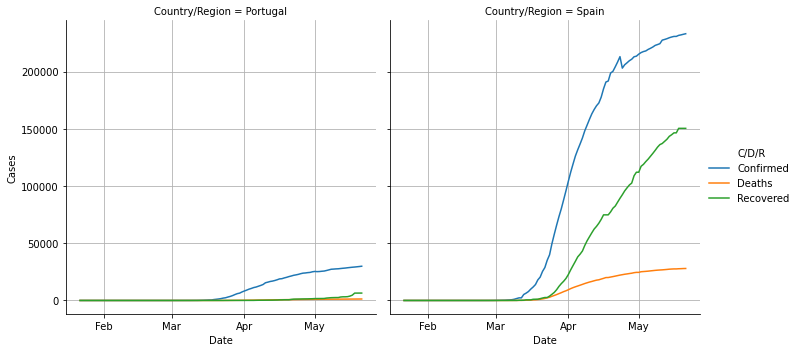

In [12]:

portugal_data = full_table.loc[(full_table['Country/Region'] == 'Portugal') | (full_table['Country/Region'] == 'Spain')]
things = ['Confirmed','Deaths','Recovered']
dd = portugal_data.melt(['Date','Country/Region','Province/State'],var_name='C/D/R', value_name='Cases',value_vars=things)


chart = sb.relplot(x='Date',y='Cases',hue='C/D/R',col='Country/Region',data=dd,kind='line')

axs = chart.axes

days = mdates.MonthLocator(interval=1)
months = mdates.MonthLocator()  # every month
days_fmt = mdates.DateFormatter('%b')

for ax in axs[0]:
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(days_fmt)
    ax.xaxis.set_minor_locator(days)

    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.grid(True)
Recovered

include = ['datetime64', 'float', 'int'] 
dd.describe(include = include).transpose()


display(dd)
portugal_data.describe().transpose()



In [13]:


X,Y = parseForNN(portugal_data)
X['Date'] = X['Date'].map(daysSinceJan)
X = X.values
Y = Y.values

nn = sknn.MLPRegressor(
    hidden_layer_sizes=(10,20,1000,20,10),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    max_iter=1000,
    verbose=True
    )

nn.fit(X,Y)



76.18178767
Iteration 502, loss = 181314630.82811862
Iteration 503, loss = 178362768.04647663
Iteration 504, loss = 176055417.71407384
Iteration 505, loss = 173385236.00105956
Iteration 506, loss = 167678198.79171443
Iteration 507, loss = 164508966.05849582
Iteration 508, loss = 160994072.76390800
Iteration 509, loss = 156975085.05293843
Iteration 510, loss = 152733575.77970660
Iteration 511, loss = 149753814.82202381
Iteration 512, loss = 148416470.70618239
Iteration 513, loss = 144704122.09150261
Iteration 514, loss = 139974196.71714684
Iteration 515, loss = 136614536.20064241
Iteration 516, loss = 133342343.05954033
Iteration 517, loss = 130287041.39895952
Iteration 518, loss = 127303614.35947374
Iteration 519, loss = 125313364.93911047
Iteration 520, loss = 122010098.86122163
Iteration 521, loss = 119436099.26316930
Iteration 522, loss = 115455104.47882509
Iteration 523, loss = 113074474.47101294
Iteration 524, loss = 110476138.92123923
Iteration 525, loss = 106823207.98716791
Iter

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 20, 1000, 20, 10),
             learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
             max_iter=1000, momentum=0.9, n_iter_no_change=10,
             nesterovs_momentum=True, power_t=0.5, random_state=None,
             shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
             verbose=True, warm_start=False)

In [14]:
display(covid_data.loc[(covid_data['Country/Region'] == 'Portugal') & (covid_data['Date'] == datetime(2020,4,2))])

NameError: name 'covid_data' is not defined

In [15]:
nn.predict([[39.3999,-8.2245,daysSinceJan(datetime(2020,5,8)) ]])

array([[19178.21355712,   597.7536148 ,   769.11741841]])